# Functional minimization

Gradient-based optimization algorithms attempt to use derivative information, for example as computed using the adjoint method, to accelerate the solution of optimization problems. A typical example is to seek the minimum of an objective cost functional, constrained using one or more partial differential equations. This notebook describes how to solve such partial differential equation constrained optimization problems using tlm_adjoint.

This example makes use of tlm_adjoint with the [Firedrake](https://firedrakeproject.org/) backend, and we assume real spaces and a real build of Firedrake throughout. The minimization problem is solved using the [Toolkit for Advanced Optimization (TAO)](https://petsc.org/release/manual/tao/).

## Forward problem

We first construct a partial differential equation constrained optimization problem where we know the answer &ndash; where we know the value of the control which minimizes the objective functional subject to the constraint that the forward problem is solved. To do this we consider the solution of the modified Helmholtz equation in the unit square domain,

$$\alpha^2 \nabla^2 u - u = m \qquad \text{on} ~ \Omega = \left( 0, 1 \right)^2,$$

where $\alpha \in \mathbb{R}$, subject to doubly periodic boundary conditions. We define an objective cost functional

$$J \left( u, m \right) = \frac{1}{2} \int_\Omega \left( u - \tilde{u} \right)^2 + \frac{1}{2} \beta^2 \int_\Omega \left( m - \tilde{m} \right)^2,$$

where $\tilde{u}$ and $\tilde{m}$ are given functions and $\beta \ne 0$ is a real scalar. If we set

$$\tilde{m} \left( x, y \right) = -\sin \left( 2 \pi x \right) \sin \left( 2 \pi y \right),$$
$$\tilde{u} \left( x, y \right) = -\frac{1}{1 + 8 \pi^2 \alpha^2} m \left( x, y \right),$$

where $x$ and $y$ are Cartesian coordinates in $\mathbb{R}^2$, then $u = \tilde{u}$ and $m = \tilde{m}$ will be the minimum of $J$ where the modified Helmholtz problem is solved.

We consider a continuous Galerkin finite element discretization, seeking $u \in V$ such that

$$\forall \zeta \in V \qquad \alpha^2 \int_\Omega \nabla \zeta \cdot \nabla u + \int_\Omega \zeta u = -\int_\Omega \zeta m,$$

where $V$ is a real continuous $P_1$ finite element space whose elements satisfy the doubly periodic boundary conditions. We now define $\tilde{m} \in V$ and $\tilde{u} \in V$ via interpolation, at mesh vertices, of the functions given above.

We first use Firedrake to solve the forward problem. We consider $\alpha = 0.1$, $\beta = 0.1$, and an 'initial guess' where $m = -1$.

In [1]:
%matplotlib inline

from firedrake import *
from tlm_adjoint.firedrake import *
from firedrake.pyplot import tricontourf

import matplotlib.pyplot as plt
import numpy as np

alpha = Constant(0.1)
beta = Constant(0.1)


def forward(m):
    space = m.function_space()
    X = SpatialCoordinate(space.mesh())
    test, trial = TestFunction(space), TrialFunction(space)

    m_tilde = Function(space, name="m_tilde").interpolate(
        -sin(2 * pi * X[0]) * sin(2 * pi * X[1]))
    u_tilde = Function(space, name="u_tilde").assign(
        -(1.0 / (1.0 + 8.0 * pi * pi * alpha * alpha)) * m_tilde)

    u = Function(space, name="u")
    solve(alpha * alpha * inner(grad(trial), grad(test)) * dx + inner(trial, test) * dx
          == -inner(m, test) * dx,
          u, solver_parameters={"ksp_type": "cg",
                                "pc_type": "sor",
                                "ksp_atol": 1.0e-32,
                                "ksp_rtol": 1.0e-12})

    J = Functional(name="J")
    J.addto(0.5 * inner(u - u_tilde, u - u_tilde) * dx)
    J.addto(0.5 * beta * beta * inner(m - m_tilde, m - m_tilde) * dx)
    return m_tilde, u, J


mesh = PeriodicSquareMesh(20, 20, 1.0)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)

m_0 = Function(space, name="m_0").interpolate(Constant(-1.0))
m_tilde, u, J = forward(m_0)

## Inverse problem

We now seek to solve the inverse problem: to find the $m \in V$ which minimizes $J$, subject to the discretized modified Helmholtz problem being solved.

In the following we use the Toolkit for Advanced Optimization (TAO) to solve the inverse problem. We use the Limited-Memory Variable Metric (LMVM) approach with an absolute tolerance of $10^{-10}$. Noting that the adjoint computed derivative is an element of the dual space $V^*$, we need to define an appropriate dual space inner product. Here we define an inner product using the inverse mass matrix, and use this to define both the initial Hessian inverse approximation, and the gradient norm.

tao_solver.tao.getIterationNumber()=7


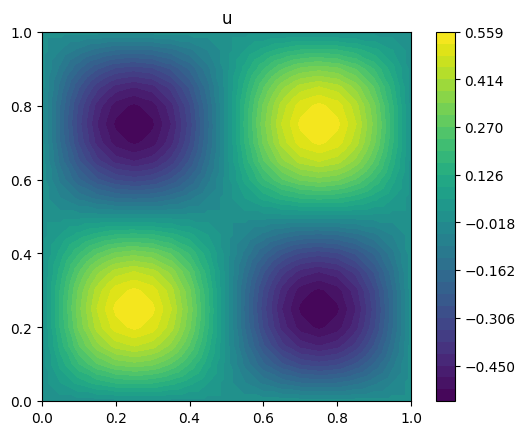

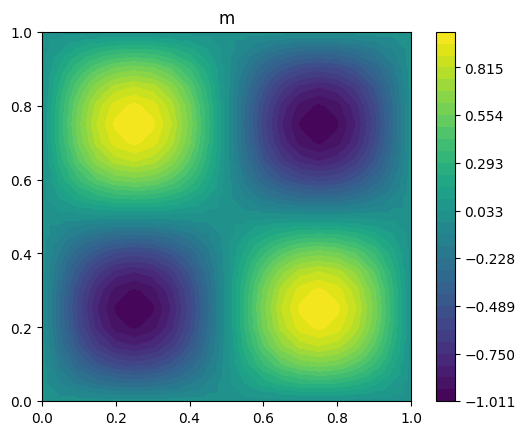

In [2]:
def forward_J(m):
    _, _, J = forward(m)
    return J


M_solver = LinearSolver(assemble(inner(TrialFunction(space), TestFunction(space)) * dx),
                        solver_parameters={"ksp_type": "cg",
                                           "pc_type": "sor",
                                           "ksp_atol": 1.0e-32,
                                           "ksp_rtol": 1.0e-12})


def M_inv_action(x):
    y = Function(space)
    M_solver.solve(y, x.copy(deepcopy=True))
    return y


tao_solver = TAOSolver(forward_J, space,
                       solver_parameters={"tao_type": "lmvm",
                                          "tao_gatol": 1.0e-10,
                                          "tao_grtol": 0.0,
                                          "tao_gttol": 0.0},
                       H_0_action=M_inv_action)
m = Function(space, name="m").assign(m_0)
tao_solver.solve(m)
print(f"{tao_solver.tao.getIterationNumber()=}")
m_tilde, u, J = forward(m)


def plot_output(u, title):
    r = (u.dat.data_ro.min(), u.dat.data_ro.max())
    eps = (r[1] - r[0]) * 1.0e-12
    p = tricontourf(u, np.linspace(r[0] - eps, r[1] + eps, 32))
    plt.gca().set_title(title)
    plt.colorbar(p)
    plt.gca().set_aspect(1.0)


plot_output(u, title="u")
plot_output(m, title="m")

We now test the inverse procedure by checking that it converges to the expected result, considering meshes with decreasing element size. We compute the $L^2$ error in each case, and estimate the order of convergence by a power law fit between the error norms computed using subsequent pairs of meshes.

In [3]:
Ns = np.array([20 * (2 ** p) for p in range(4)], dtype=int)
error_norms = []
for N in Ns:
    mesh = PeriodicSquareMesh(N, N, 1.0)
    X = SpatialCoordinate(mesh)
    space = FunctionSpace(mesh, "Lagrange", 1)

    m_0 = Function(space, name="m_0").interpolate(Constant(-1.0))

    M_solver = LinearSolver(assemble(inner(TrialFunction(space), TestFunction(space)) * dx),
                            solver_parameters={"ksp_type": "cg",
                                               "pc_type": "sor",
                                               "ksp_atol": 1.0e-32,
                                               "ksp_rtol": 1.0e-12})

    def M_inv_action(x):
        y = Function(space)
        M_solver.solve(y, x.copy(deepcopy=True))
        return y

    tao_solver = TAOSolver(forward_J, space,
                           solver_parameters={"tao_type": "lmvm",
                                              "tao_gatol": 1.0e-10,
                                              "tao_grtol": 0.0,
                                              "tao_gttol": 0.0},
                           H_0_action=M_inv_action)
    m = Function(space, name="m").assign(m_0)
    tao_solver.solve(m)
    print(f"{tao_solver.tao.getIterationNumber()=}")
    m_tilde, u, J = forward(m)

    m_error_norm = sqrt(abs(assemble(inner(m - m_tilde, m - m_tilde) * dx)))
    print(f"{N=} {m_error_norm=}")
    error_norms.append(m_error_norm)
error_norms = np.array(error_norms, dtype=float)

orders = -np.log(error_norms[1:] / error_norms[:-1]) / np.log(Ns[1:] / Ns[:-1])
print(f"{orders=}")

assert (orders > 1.99).all()

tao_solver.tao.getIterationNumber()=7


N=np.int64(20) m_error_norm=0.006304152669626421


tao_solver.tao.getIterationNumber()=10
N=np.int64(40) m_error_norm=0.0015825703856270482


tao_solver.tao.getIterationNumber()=10
N=np.int64(80) m_error_norm=0.0003960451269394697


tao_solver.tao.getIterationNumber()=8
N=np.int64(160) m_error_norm=9.903646649061314e-05
orders=array([1.99403281, 1.99853293, 1.99963308])


We find that we have close to second order convergence.